In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sys

# Add the directory containing fs.py to the Python path
sys.path.append('./modules')

# Assuming FuzzySystemLayer and create_fuzzy_model are defined in fs.py
from fs import FuzzySystemLayer, create_fuzzy_model

In [11]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Impute missing values in 'value' and 'classification_numerical' columns
imputer = SimpleImputer(strategy='mean')
X_train[['value', 'classification_numerical']] = imputer.fit_transform(X_train[['value', 'classification_numerical']])

# Verify that there are no NaN values left
print("NaN values in X_train after imputation:\n", X_train.isna().sum().sum())

# Check for extreme values in the data
print("Extreme values in X_train:", (X_train > 1e9).sum().sum())

# Exclude non-numerical columns before scaling
columns_to_scale = X_train.columns  # All columns in X_train are numerical

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features
X_train_scaled = scaler_X.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler_X.transform(X_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


NaN values in X_train after imputation:
 0
Extreme values in X_train: 2367


## Function to Save Models

In [12]:
import os
import pickle
from datetime import datetime

def save_model_and_scalers(model, scaler_X, scaler_y, model_type):
    """
    Save the Keras model and scalers with a timestamp and type in a directory using pickle.

    Parameters:
    - model: The trained Keras model to be saved.
    - scaler_X: The MinMaxScaler object for the features.
    - scaler_y: The MinMaxScaler object for the target variable.
    - model_type: A string representing the type of the model (e.g., "RNN", "LSTM").
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"saved_models/{model_type}"  # Create a directory with the model name
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    model_filename = f"{save_dir}/{model_type}_model_{timestamp}.h5"
    model.save(model_filename)

    # Save the scalers
    scalers_filename = f"{save_dir}/{model_type}_scalers_{timestamp}.pkl"
    with open(scalers_filename, 'wb') as f:
        pickle.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, f)

    print(f"Model saved to {model_filename}")
    print(f"Scalers saved to {scalers_filename}")

## Tuning Fuzzy model

In [14]:
import optuna
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm

# Determine the optimal number of clusters (e.g., using domain knowledge, elbow method, etc.)
n_clusters = 3  # This is a placeholder; adjust based on our analysis

# Steps for cluster determination remain the same
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_scaled)
cluster_centers = kmeans.cluster_centers_
def create_objective(X_train_scaled, y_train_scaled, cluster_centers):
    def objective(trial):
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        initializer_stddev = trial.suggest_float('initializer_stddev', 0.01, 0.1)
        
        model = create_fuzzy_model(
            input_dim=X_train_scaled.shape[1],
            cluster_centers=cluster_centers,
            output_dim=1,
            learning_rate=learning_rate,
            initializer_stddev=initializer_stddev
        )
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            X_train_scaled,
            y_train_scaled,
            validation_split=0.2,
            epochs=50,
            callbacks=[early_stopping],
            verbose=0
        )
        
        best_val_loss = min(history.history['val_loss'])
        return best_val_loss
    return objective

objective_function = create_objective(X_train_scaled, y_train_scaled, cluster_centers)
study = optuna.create_study(direction='minimize')

# Wrap the study.optimize call with tqdm for a progress bar
n_trials = 50
with tqdm(total=n_trials, desc="Optimize") as pbar:
    def callback(study, trial):
        # Update the progress bar after each trial
        pbar.update(1)
    study.optimize(objective_function, n_trials=n_trials, callbacks=[callback])

print('Number of finished trials:', len(study.trials))
# After optimization process
best_hyperparams = study.best_trial.params
print(f"Best hyperparameters: {best_hyperparams}")

# Now, we can safely use `best_hyperparams` to retrain our model
best_model = create_fuzzy_model(
    input_dim=X_train_scaled.shape[1],
    cluster_centers=cluster_centers,
    output_dim=1,
    learning_rate=best_hyperparams['learning_rate'],
    initializer_stddev=best_hyperparams['initializer_stddev']
)

best_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

# Save the model and scalers after training
save_model_and_scalers(best_model, scaler_X, scaler_y, "Fuzzy_sklearn_version_tuned")

y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
print(f"Mean Squared Error (MSE) on Test Set: {mse_test}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")




[I 2024-06-02 00:42:54,753] A new study created in memory with name: no-name-b8edd31c-bebe-4b66-86d2-ea426caa4fa4


Optimize:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-02 00:42:55,610] Trial 0 finished with value: 0.019692352041602135 and parameters: {'learning_rate': 0.004098673354408098, 'initializer_stddev': 0.041796412263881755}. Best is trial 0 with value: 0.019692352041602135.
[I 2024-06-02 00:42:56,141] Trial 1 finished with value: 0.019039960578083992 and parameters: {'learning_rate': 0.004927114040295647, 'initializer_stddev': 0.026721552122223435}. Best is trial 1 with value: 0.019039960578083992.
[I 2024-06-02 00:42:56,570] Trial 2 finished with value: 0.017224902287125587 and parameters: {'learning_rate': 0.008503742562244117, 'initializer_stddev': 0.04623764478247822}. Best is trial 2 with value: 0.017224902287125587.
[I 2024-06-02 00:42:57,781] Trial 3 finished with value: 0.052408818155527115 and parameters: {'learning_rate': 0.0003612324992986464, 'initializer_stddev': 0.09444213690181574}. Best is trial 2 with value: 0.017224902287125587.
[I 2024-06-02 00:42:59,000] Trial 4 finished with value: 0.027811603620648384 and par

Number of finished trials: 50
Best hyperparameters: {'learning_rate': 0.008503742562244117, 'initializer_stddev': 0.04623764478247822}
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.0195 - val_loss: 0.1570
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.0063 - val_loss: 0.0896
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.0040 - val_loss: 0.0465
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 0.0027 - val_loss: 0.0301
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 0.0025 - val_loss: 0.0225
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 0.0024 - val_loss: 0.0248
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.0022 - val_loss: 0.0200
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0023 - val_loss: 0.0199
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.0023 - val_loss: 0.0219
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.0023 - val_loss: 0

Model saved to saved_models/Fuzzy_sklearn_version_tuned/Fuzzy_sklearn_version_tuned_model_20240602_004333.h5
Scalers saved to saved_models/Fuzzy_sklearn_version_tuned/Fuzzy_sklearn_version_tuned_scalers_20240602_004333.pkl
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
Mean Squared Error (MSE) on Test Set: 389156922.6876468
Root Mean Squared Error (RMSE) on Test Set: 19727.060670248033


In [15]:
import pandas as pd

# Recreate the datetime column from the index (assuming the index was a datetime index)
if 'datetime' not in X_test.columns:
    X_test['datetime'] = pd.to_datetime(X_test.index)

print("Available columns in X_test after adding datetime:", X_test.columns)


Available columns in X_test after adding datetime: Index(['open', 'volume', 'sma_30', 'rsi', 'macd', 'dia_close', 'dia_volume',
       'gld_close', 'gld_volume', 'spy_close', 'spy_volume',
       'federal_funds_rate_daily', 'treasury_yield_daily', 'cpi_monthly',
       'durables_monthly', 'nonfarm_payroll_monthly',
       'real_gdp_per_capita_quarterly', 'real_gdp_quarterly',
       'retail_sales_monthly', 'unemployment_monthly',
       'central_bank_policy_rate_prcnt', 'domestic_credit_gdp',
       'foreign_direct_investment_value', 'gdp_growth_annual_prcnt',
       'inflation_rate_value',
       'individuals_using_the_internet_prcnt_of_population',
       'mobile_cellular_subscriptions_per_100_people',
       'personal_remittances_received_prcnt_of_gdp',
       'stock_market_index_value', 'tariffs_value',
       'total_public_debt_gdp_value', 'trade_balance_value',
       'trade_in_services_value', 'unemployment_rate_value', 'value',
       'classification_numerical', 'datetime'],
  

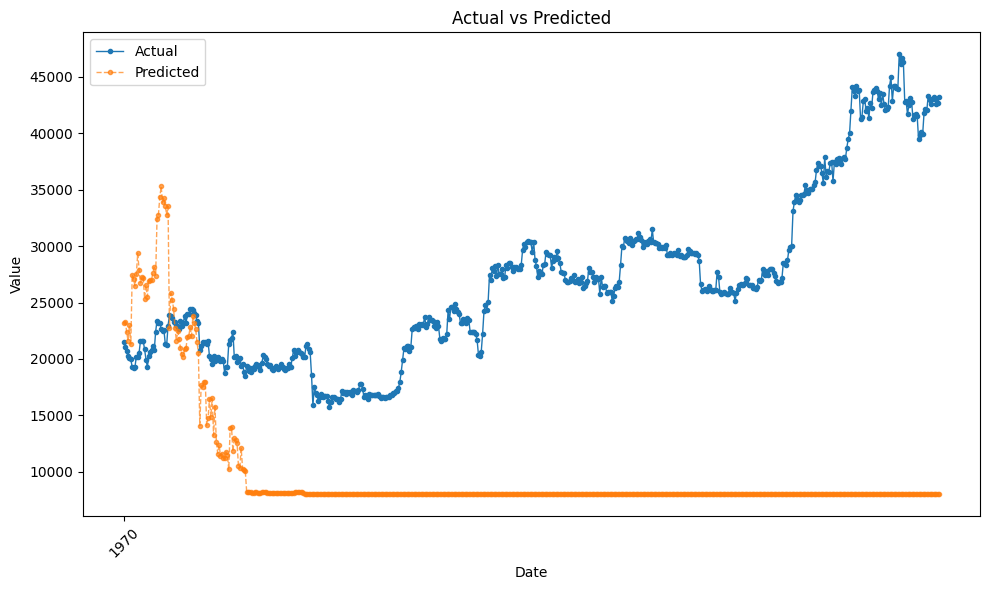

In [16]:
import matplotlib.pyplot as plt
y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
# Assuming y_test_original and y_pred are correctly aligned with these dates
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--', linewidth=1)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Improve readability of the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()